In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from pandas.api.types import CategoricalDtype

In [3]:
market_sentiment_df=pd.read_csv('merged_data.csv')

In [5]:
market_sentiment_df.head()

,Coin,Execution Price,Size Tokens,Size USD,Side,Start Position,Closed PnL,Fee,date,value,classification
0,@107,7.9769,986.87,7872.16,BUY,0.000000,0.0,0.345404,2024-12-02,80.0,Extreme Greed
1,@107,7.9800,16.00,127.68,BUY,986.524596,0.0,0.005600,2024-12-02,80.0,Extreme Greed
2,@107,7.9855,144.09,1150.63,BUY,1002.518996,0.0,0.050431,2024-12-02,80.0,Extreme Greed
3,@107,7.9874,142.98,1142.04,BUY,1146.558564,0.0,0.050043,2024-12-02,80.0,Extreme Greed
4,@107,7.9894,8.73,69.75,BUY,1289.488521,0.0,0.003055,2024-12-02,80.0,Extreme Greed


In [ ]:

# Define desired order
classification_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

# Convert to ordered category
cat_type = CategoricalDtype(categories=classification_order, ordered=True)
market_sentiment_df['classification'] = market_sentiment_df['classification'].astype(cat_type)



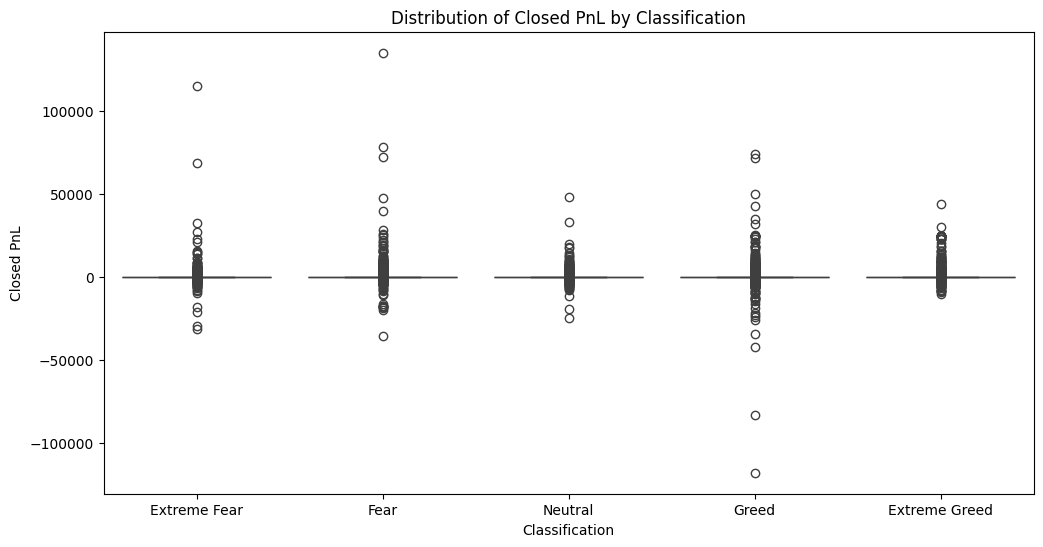

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=market_sentiment_df, x='classification', y='Closed PnL')
plt.title('Distribution of Closed PnL by Classification')
plt.xlabel('Classification')
plt.ylabel('Closed PnL')    
plt.show()


In [24]:
# Average Trade Size (USD) by Sentiment
avg_trade_size = market_sentiment_df.groupby('classification', observed=True)['Size USD'].mean()
print(avg_trade_size)


classification
Extreme Fear     5349.731843
Fear             7816.109931
Neutral          4782.732661
Greed            5736.884375
Extreme Greed    3112.251565
Name: Size USD, dtype: float64


C:\Users\ARIN\AppData\Local\Temp\ipykernel_14232\1970241716.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trade_counts = market_sentiment_df.groupby(['classification', 'Side']).size().unstack()


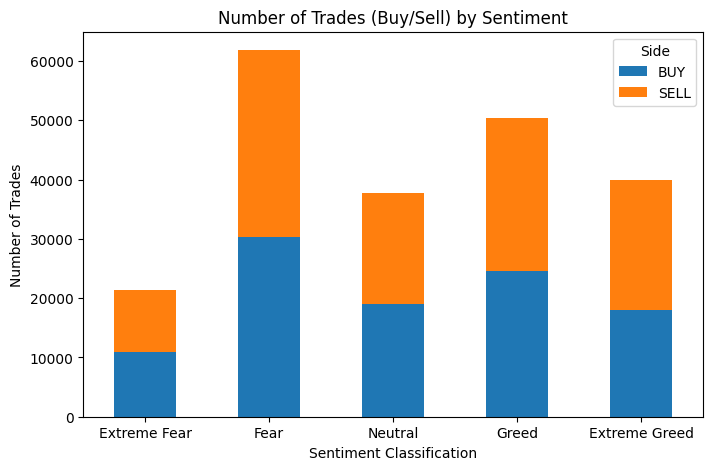

In [30]:
# Number of Trades by Side and Sentiment
trade_counts = market_sentiment_df.groupby(['classification', 'Side']).size().unstack()
trade_counts.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title("Number of Trades (Buy/Sell) by Sentiment")
plt.ylabel("Number of Trades")
plt.xlabel("Sentiment Classification")
plt.xticks(rotation=0)
plt.show()

In [ ]:
#Win Rate by Sentiment
market_sentiment_df['win'] = market_sentiment_df['Closed PnL'] > 0
win_rate = market_sentiment_df.groupby('classification', observed=True)['win'].mean() * 100
print("Win Rate by Sentiment Classification:")
print(win_rate)

Win Rate by Sentiment Classification:
 classification
Extreme Fear     37.060748
Fear             42.076750
Neutral          39.699093
Greed            38.482794
Extreme Greed    46.494299
Name: win, dtype: float64


In [ ]:
# Statistical Test: PnL difference on Greed vs Fear days
greed_pnl = market_sentiment_df[market_sentiment_df['classification'] == 'Greed']['Closed PnL']
fear_pnl = market_sentiment_df[market_sentiment_df['classification'] == 'Fear']['Closed PnL']

if not greed_pnl.empty and not fear_pnl.empty:
    t_stat, p_value = ttest_ind(greed_pnl, fear_pnl, equal_var=False)
    print(f"T-Statistic: {t_stat:.3f}, P-Value: {p_value:.5f}")
else:
    print("Not enough data for Greed and Fear to perform T-Test.")



T-Statistic: -1.851, P-Value: 0.06415


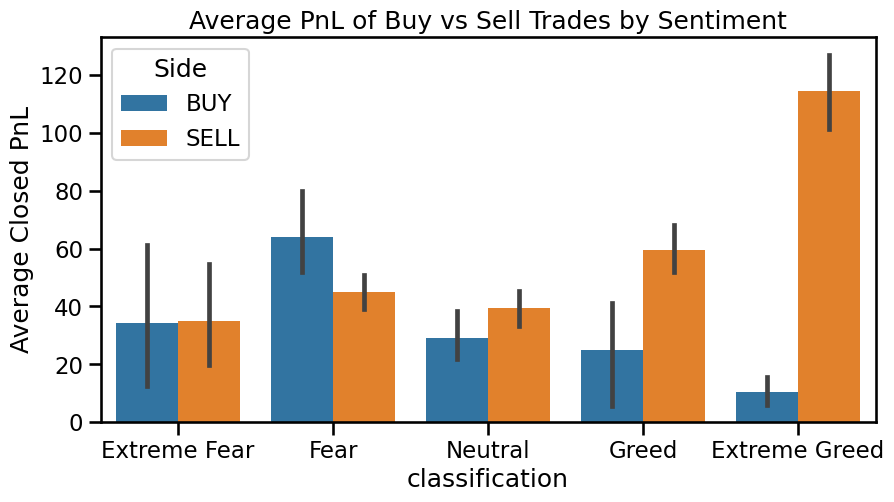

In [75]:
plt.figure(figsize=(10,5))
sns.barplot(x='classification', y='Closed PnL', hue='Side', data=market_sentiment_df)
plt.title('Average PnL of Buy vs Sell Trades by Sentiment')
plt.ylabel('Average Closed PnL')
plt.xticks(rotation=0)
plt.show()


Average Fee to PnL Ratio by Sentiment Classification:
classification
Extreme Fear     0.054348
Fear             0.088189
Neutral          0.124295
Greed            0.072171
Extreme Greed    0.033443
Name: fee_ratio, dtype: float64


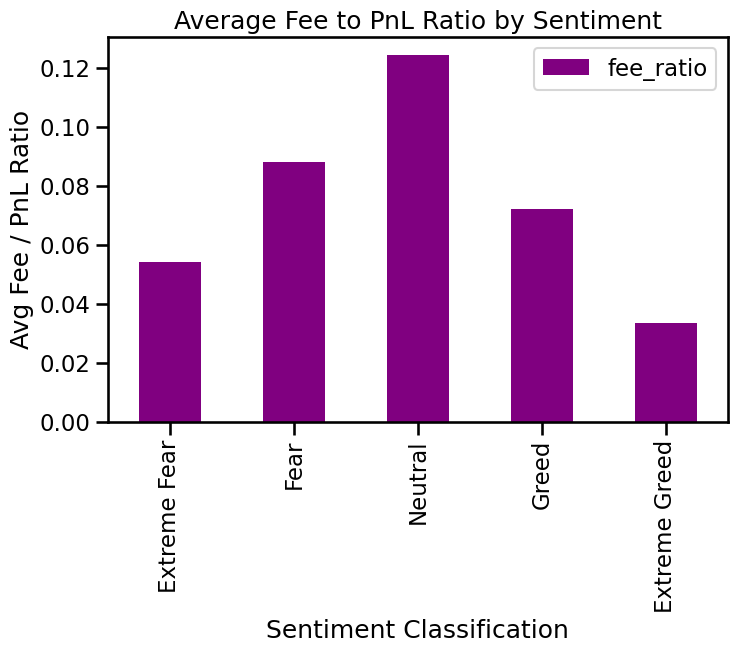

In [ ]:
# Calculate Fee as % of Closed PnL (avoid divide by zero)
market_sentiment_df['fee_ratio'] = market_sentiment_df.apply(
    lambda x: x['Fee'] / abs(x['Closed PnL']) if x['Closed PnL'] != 0 else 0, axis=1)

# Average fee ratio per sentiment
fee_impact = market_sentiment_df.groupby('classification', observed=True)['fee_ratio'].mean()
print("Average Fee to PnL Ratio by Sentiment Classification:")
print(fee_impact)

# Visualize
fee_impact.plot(kind='bar', figsize=(8,5), color='purple', title='Average Fee to PnL Ratio by Sentiment')
plt.ylabel('Avg Fee / PnL Ratio')
plt.xlabel('Sentiment Classification')
plt.xticks(rotation=90)
plt.legend()
plt.show()


C:\Users\ARIN\AppData\Local\Temp\ipykernel_14232\2642315829.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = market_sentiment_df.groupby(['day_of_week', 'classification'])['Closed PnL'].mean().unstack()


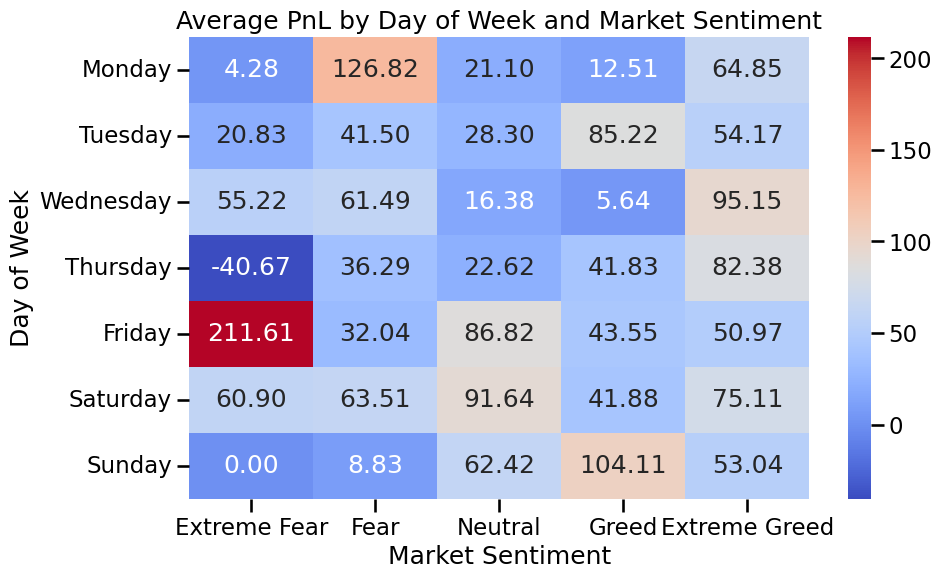

In [68]:
market_sentiment_df['date'] = pd.to_datetime(market_sentiment_df['date'])

# Extract day of week
market_sentiment_df['day_of_week'] = market_sentiment_df['date'].dt.day_name()

# Avg PnL by day and sentiment
heatmap_data = market_sentiment_df.groupby(['day_of_week', 'classification'])['Closed PnL'].mean().unstack()

# Heatmap
heatmap_data = heatmap_data.reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
    axis=0
).fillna(0)  # Fill NaN values with 0 for better visualization
plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Average PnL by Day of Week and Market Sentiment')
plt.ylabel('Day of Week')
plt.xlabel('Market Sentiment')
plt.show()

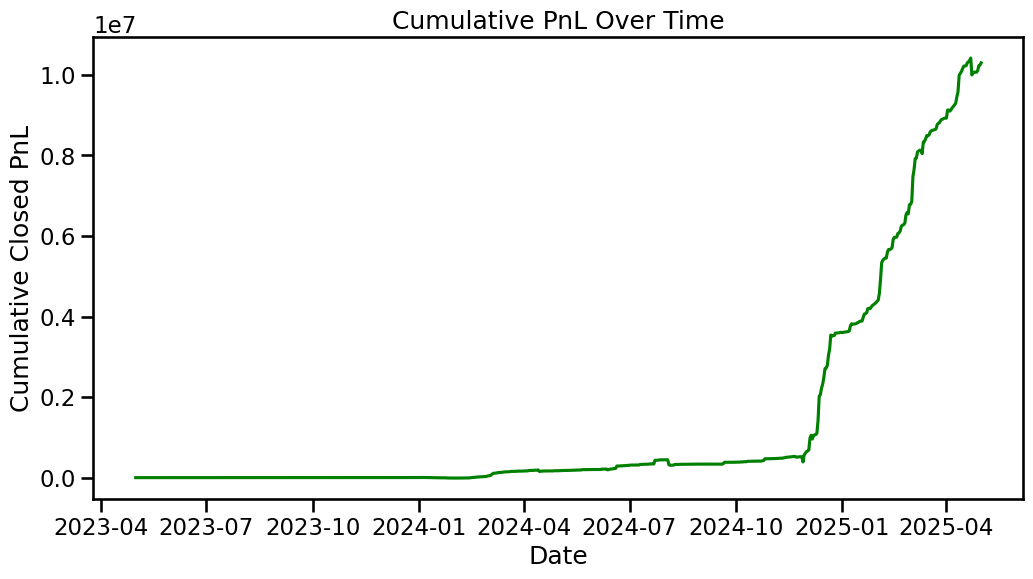

In [73]:
# Cumulative PnL over time
market_sentiment_df['date'] = pd.to_datetime(market_sentiment_df['date'])
market_sentiment_df.sort_values('date', inplace=True)
cumulative_pnl = market_sentiment_df.groupby('date')['Closed PnL'].sum().cumsum()

plt.figure(figsize=(12,6))
plt.plot(cumulative_pnl, color='green')
plt.title('Cumulative PnL Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Closed PnL')
plt.show()
